<h1> New NACOSA data </h1>

In [1]:
from __future__ import division
import psycopg2
import numpy as np
import json
import re
from ast import literal_eval
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import gzip
from IPython.html.widgets import *

from nvd3 import multiBarChart
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

from IPython.html.widgets import *

Populating the interactive namespace from numpy and matplotlib


/Users/attiladobi/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


loaded nvd3 IPython extension
run nvd3.ipynb.initialize_javascript() to set up the notebook
help(nvd3.ipynb.initialize_javascript) for options


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
quarter_map={0:(0,0),1:(1,1),2:(1,2),3:(2,3),4:(2,4),5:(3,1),6:(3,2),7:(4,3),8:(4,4),9:(5,1),10:(5,2),11:(6,3),12:(6,4)}

def find_sheet_name(target_text,sheet_names):
    '''Return a list of sheet names containing a specific string'''
    return [name for name in sheet_names if target_text.lower() in name.lower()]
def find_column_name(target,columns):
    return [name for name in columns if target.lower() in name.lower()]

def month_diff(b,a):
    '''month differnece between two pandas datetime objects'''
    return (b.month - a.month + (b.year - a.year)*12)

def pq_lookup(date):
    '''retun period, quarter given a date: pd.datetime(year,month,day)'''
    #3 month index to period quarter
    #quarter_map={0:(0,0), 1:(1,1),2:(1,2),3:(2,3),4:(2,4),5:(3,1),6:(3,2),7:(4,3),8:(4,4),9:(5,1),10:(5,2),11:(6,3),12:(6,4)}
    qnum=1+int(floor(month_diff(date,pd.datetime(2016,4,1))/3))
    try:
        p,q=quarter_map[qnum]
    except KeyError:
        p,q=(0,0)
    return p,q,qnum

def getYearMonth(s):
    return '%s-%s-01' % (s.year, s.month)

<h1> load in the data </h1>

In [6]:
# read the entire file into a python array
#use: with open('file path','rb') as f #without gzip
with gzip.open('/Users/attiladobi/zenysis/pipeline/out/za/out/shared/20161222/za_integration.json.gz', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF = pd.read_json(data_json_str)

#convert date:
#DF['Date']=pd.to_datetime(DF['Real_Date'])
#DF['day'] = DF['Date'].dt.day
#DF['month'] = DF['Date'].dt.month
#DF['year'] = DF['Date'].dt.year
#DF['YearMonth'] = DF['Date'].dt.strftime('%Y-%m-01')
#DF['YearMonth'] = DF['Date'].apply(lambda x: getYearMonth(x))

#ADD Quarter grouping to the data
#DF['qNum']=[pq_lookup(date)[2] for date in DF['Date'].dt.values] #need the .dt to convert to dt index
#DF['subrecipient']=DF['subrecipient'].replace('nqobile women','nqobile')
#standardize names
#DF['field']=DF['field'].replace('red_umbrella_male_condom_lube','f_1_male_condoms_number_given')
#DF=DF.drop_duplicates()

In [7]:
len(DF) #-len(DF.drop_duplicates())

1248573

<h1> test drop duplicate code </h1>

In [4]:
import json
from collections import defaultdict
import time

with gzip.open('/Users/attiladobi/zenysis/pipeline/out/za/out/shared/20161206/za_integration.json.gz', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
ds = json.loads(data_json_str)

In [6]:
#loop through the entries. The key will be all of the columns and values
start = time.time()
ds = json.loads(data_json_str)
S=defaultdict(lambda:0)
f = gzip.open('test_pandas4.json.gz', "w")
for each in ds:
    S[str(each)]+=1
    if S[str(each)]==1:
        f.write(json.dumps(each)+'\n')
f.close()

print time.time()-start

113.732665062


<h1> even faster, write while reading current file </h1>

In [34]:
start = time.time()
S=defaultdict(lambda:0)
w = gzip.open('test_pandas4.json.gz', "w")
with gzip.open('/Users/attiladobi/zenysis/pipeline/out/za/out/shared/20161206/za_integration.json.gz', 'rb') as f:
    for line in f:
        data=line.rstrip()
        #data_json_str = "[" + ','.join(data) + "]"
        #ds = json.loads(data_json_str)
        S[data]+=1
        if S[data]==1:
            w.write(data+'\n')
w.close()
print time.time()-start

33.1529300213


In [33]:
data

'{"budget_line": "167", "budget_line_full": "167: child and youth care worker/chb carer and sweat", "description": "child and youth care worker/chb carer and sweat", "val": 16030.2121875, "field": "variance", "Real_Date": "2016-04-01", "cost_category": "human resources", "source": "", "subrecipient": "munna ndi nnyi"}'

In [ ]:
start = time.time()
#DF = pd.read_json(data_json_str)
#DF=DF.drop_duplicates()
f = gzip.open('test_pandasB.json.gz', "w")
for i,row in enumerate(DF.iterrows()):
    row[1].dropna().to_json(f) #painfully slow with dropna
    f.write('\n')
    if i%100000==0:
        print i
f.close()
print time.time()-start

<h1> look at DF </h1>

In [5]:
DF[:100].head()

,Real_Date,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,field,...,suburb,supplier_employee_name,transaction_reference,unique_id,val,Date,day,month,year,qNum
0,2016-04-01,NaN,NaN,167,167: child and youth care worker/chb carer and...,NaN,human resources,child and youth care worker/chb carer and sweat,NaN,variance,...,NaN,NaN,NaN,NaN,16030.212187,2016-04-01,1,4,2016,1
1,2016-04-01,NaN,NaN,167,167: child and youth care worker/chb carer and...,NaN,human resources,child and youth care worker/chb carer and sweat,NaN,budget,...,NaN,NaN,NaN,NaN,16030.212187,2016-04-01,1,4,2016,1
2,2016-04-01,NaN,NaN,167,167: child and youth care worker/chb carer and...,NaN,human resources,child and youth care worker/chb carer and sweat,NaN,spend,...,NaN,NaN,NaN,NaN,0.000000,2016-04-01,1,4,2016,1
3,2016-06-01,NaN,NaN,167,167: child and youth care worker/chb carer and...,NaN,human resources,child and youth care worker/chb carer and sweat,NaN,variance,...,NaN,NaN,NaN,NaN,-9362.107813,2016-06-01,1,6,2016,1
4,2016-06-01,NaN,NaN,167,167: child and youth care worker/chb carer and...,NaN,human resources,child and youth care worker/chb carer and sweat,NaN,budget,...,NaN,NaN,NaN,NaN,16030.212187,2016-06-01,1,6,2016,1


In [5]:
DF.columns

Index([             u'Real_Date',            u'beneficiary',
                        u'birth',            u'budget_line',
             u'budget_line_full',               u'comments',
                u'cost_category',            u'description',
                     u'district',                  u'field',
                       u'gender', u'invoice_receipt_number',
               u'peer_motivator',               u'province',
                 u'province_lat',           u'province_lng',
                         u'site',               u'site_lat',
                     u'site_lng',                 u'source',
                 u'subrecipient',                 u'suburb',
       u'supplier_employee_name',  u'transaction_reference',
                    u'unique_id',                    u'val',
                         u'Date',                    u'day',
                        u'month',                   u'year',
                         u'qNum'],
      dtype='object')

In [8]:
DF.groupby('gender').count().index

Index([u'``', u'c', u'female', u'male', u'missing', u'msm', u'trasngender'], dtype='object', name=u'gender')

In [9]:
DF.loc[DF['gender']=='c']['beneficiary']

783399    ronia ngxazana
783400    ronia ngxazana
783401    ronia ngxazana
783402    ronia ngxazana
Name: beneficiary, dtype: object

<h1> Check SR names </h1>

In [19]:
DF.loc[DF['province']=='free state'].groupby(['subrecipient','province']).count()

,,Real_Date,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,field,...,suburb,supplier_employee_name,transaction_reference,unique_id,val,Date,day,month,year,qNum
subrecipient,province,,,,,,,,,,,,,,,,,,,,,
lljbh,free state,1290,1290,1290,0,0,1290,0,0,0,1290,...,1290,0,0,1290,1290,1290,1290,1290,1290,1290
qlac,free state,7345,7231,7231,0,0,7231,0,114,114,7345,...,7231,0,0,7231,7345,7345,7345,7345,7345,7345


In [14]:
#DF.loc[(DF['province']=='free state') ][['field','val','beneficiary','unique_id','gender','province','subrecipient']]

<h1>SR names </h1>

In [10]:
DF.groupby(['subrecipient']).count()
#DF.loc[DF['field'].str.contains('hct')].groupby(['subrecipient']).count()

,Real_Date,age,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,...,province_lng,site,site_lat,site_lng,source,suburb,supplier_employee_name,transaction_reference,unique_id,val
subrecipient,,,,,,,,,,,,,,,,,,,,,
control,114,0,0,0,0,0,0,0,114,114,...,0,0,0,0,114,0,0,0,0,114
cpc,227765,194457,194457,194457,32690,32690,194457,32690,31382,618,...,194831,194457,194831,194831,227765,194457,1926,1926,194457,227765
grip,58997,58997,58997,58997,0,0,58997,0,0,0,...,58997,58997,58997,58997,58997,58997,0,0,58997,58997
htt,46868,46626,46626,46626,242,242,46626,242,242,0,...,46626,46626,46626,46626,46868,46626,0,0,46626,46868
humana,98,0,0,0,0,0,0,0,98,98,...,98,0,98,98,98,0,0,0,0,98
lljbh,165354,164454,164454,164454,802,802,164454,802,900,98,...,164552,164454,164552,164552,165354,164454,0,0,164454,165354
munna,19562,19562,19562,19562,0,0,19562,0,0,0,...,0,19562,0,0,19562,19562,0,0,19562,19562
munna ndi nnyi,260,0,0,0,260,260,0,260,260,0,...,0,0,0,0,260,0,0,0,0,260
nqobile,58553,27364,27364,27364,31075,31075,27364,31075,30783,114,...,27478,27364,27478,27478,58553,27364,401,406,27364,58553


<h1> M&E breakdown. district, province </h1>

In [11]:
DF.loc[(DF['field']=='f1_number_of_male_condoms_distributed') & (DF['subrecipient']=='wrhi')].groupby(['subrecipient']).val.sum()

Series([], Name: val, dtype: float64)

<h1> budget data </h1>

In [11]:
DF.loc[DF['field'].str.contains('spend')].groupby(['subrecipient']).count() #budget_line

,Real_Date,age,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,...,province_lng,site,site_lat,site_lng,source,suburb,supplier_employee_name,transaction_reference,unique_id,val
subrecipient,,,,,,,,,,,,,,,,,,,,,
cpc,12945,0,0,0,12945,12945,0,12945,12945,0,...,0,0,0,0,12945,0,0,0,0,12945
htt,85,0,0,0,85,85,0,85,85,0,...,0,0,0,0,85,0,0,0,0,85
lljbh,276,0,0,0,276,276,0,276,276,0,...,0,0,0,0,276,0,0,0,0,276
munna ndi nnyi,94,0,0,0,94,94,0,94,94,0,...,0,0,0,0,94,0,0,0,0,94
nqobile,12911,0,0,0,12911,12911,0,12911,12911,0,...,0,0,0,0,12911,0,0,0,0,12911
oasis,12913,0,0,0,12913,12913,0,12913,12913,0,...,0,0,0,0,12913,0,0,0,0,12913
phru,13055,0,0,0,13055,13055,0,13055,13055,0,...,0,0,0,0,13055,0,0,0,0,13055
psh,84,0,0,0,84,84,0,84,84,0,...,0,0,0,0,84,0,0,0,0,84
qlac,12954,0,0,0,12954,12954,0,12954,12954,0,...,0,0,0,0,12954,0,0,0,0,12954


<h1> Target data. Broken down by sr, distric, province (only quarterly) </h1>

In [12]:
DF.loc[DF['field'].str.contains('target')].groupby(['subrecipient','district','province','description']).count()

Real_Date  \
subrecipient district                      province     description                 
cpc          bojanala                      north west   non-transition        114   
             capricorn                     limpopo      transition             16   
             ekurhuleni                    gauteng      non-transition        114   
             vhembe                        limpopo      transition             16   
             waterberg                     limpopo      transition             16   
             west rand                     gauteng      non-transition         98   
humana       west rand                     gauteng      non-transition         98   
lljbh        johannesburg                  gauteng      non-transition         98   
nqobile      sedibeng                      gauteng      non-transition        114   
oasis        johannesburg                  gauteng      non-transition        114   
phru         johannesburg                  gauteng      non-transition        114   
qlac         thabo mofutsanyane            free state   non-transition        114   
sweat        buffalo city                  eastern cape non-transition        106   
             cape town                     western cape non-transition        103   
             cape winelands                western cape transition             16   
             city of cape town, west coast western cape transition             16   
             eden                          western cape transition             16   
tbhiv        cape town                     western cape non-transition        106   
wrhi         johannesburg                  gauteng      non-transition        114   

                                                                        age  \
subrecipient district                      province     description           
cpc          bojanala                      north west   non-transition    0   
             capricorn                     limpopo      transition        0   
             ekurhuleni                    gauteng      non-transition    0   
             vhembe                        limpopo      transition        0   
             waterberg                     limpopo      transition        0   
             west rand                     gauteng      non-transition    0   
humana       west rand                     gauteng      non-transition    0   
lljbh        johannesburg                  gauteng      non-transition    0   
nqobile      sedibeng                      gauteng      non-transition    0   
oasis        johannesburg                  gauteng      non-transition    0   
phru         johannesburg                  gauteng      non-transition    0   
qlac         thabo mofutsanyane            free state   non-transition    0   
sweat        buffalo city                  eastern cape non-transition    0   
             cape town                     western cape non-transition    0   
             cape winelands                western cape transition        0   
             city of cape town, west coast western cape transition        0   
             eden                          western cape transition        0   
tbhiv        cape town                     western cape non-transition    0   
wrhi         johannesburg                  gauteng      non-transition    0   

                                                                        beneficiary  \
subrecipient district                      province     description                   
cpc          bojanala                      north west   non-transition            0   
             capricorn                     limpopo      transition                0   
             ekurhuleni                    gauteng      non-transition            0   
             vhembe                        limpopo      transition                0   
             waterberg                     limpopo      transition                0   
             west

<h3> Target data and M&E data are broken down to districs and provinces. The Budget data is only at the SR level </h3>

<h1> check field names </h1>

In [13]:
DF.groupby('field').count()

,Real_Date,age,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,...,site,site_lat,site_lng,source,subrecipient,suburb,supplier_employee_name,transaction_reference,unique_id,val
field,,,,,,,,,,,,,,,,,,,,,
a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,259209,259209,259209,259209,0,0,259209,0,0,0,...,259209,232577,232577,259209,259209,259209,0,0,259209,259209
a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach,259209,259209,259209,259209,0,0,259209,0,0,0,...,259209,232577,232577,259209,259209,259209,0,0,259209,259209
amount_allocated_to_global_fund,1328,0,0,0,1326,1326,0,1325,0,0,...,0,0,0,1328,1328,0,1327,1328,0,1328
amount_excluding_vat,1325,0,0,0,1323,1323,0,1322,0,0,...,0,0,0,1325,1325,0,1324,1325,0,1325
amount_including_vat,1330,0,0,0,1328,1328,0,1327,0,0,...,0,0,0,1330,1330,0,1329,1330,0,1330
amount_paid,1300,0,0,0,1298,1298,0,1297,0,0,...,0,0,0,1300,1300,0,1299,1300,0,1300
b1_number_of_sex_workers_that_have_received_an_hiv_test_during_the_reporting_period_and_know_their_results,17446,17446,17446,17446,0,0,17446,0,0,0,...,17446,16181,16181,17446,17446,17446,0,0,17446,17446
b2_number_of_sex_workers_who_tested_hiv_negative_in_the_reporting_period,1505,1505,1505,1505,0,0,1505,0,0,0,...,1505,746,746,1505,1505,1505,0,0,1505,1505
b3_number_of_newly_diagnosed_hiv_positive_sex_workers,547,547,547,547,0,0,547,0,0,0,...,547,396,396,547,547,547,0,0,547,547


In [ ]:
DF.loc[DF['field'].str.contains('target')].groupby(['field','district','description']).count()

In [24]:
DF['Date'][0].year

2016

<h1> Aggregate M&E </h1>

<h3> the number of unique people reached per quarter </h3>

In [5]:
Indicator='a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach'
unique_people_per_m=DF.loc[(DF['field']==Indicator)\
                        & (DF['qNum']>0)].groupby(['subrecipient','YearMonth']).unique_id.nunique()

#use val.sum

#count_new_quarter=DF.loc[(DF['field'].str.contains("counter_1_first_outreach_for_quarter")) & (DF['year']==2016) \
#       & (DF['Quarter']>=1) & (DF['Quarter']<=2)]\
#.groupby(['Quarter','subrecipient']).beneficiary.nunique()

#unique_people_per_q

In [6]:
unique_people_per_m

subrecipient  YearMonth
cpc           2016-4-1      894
              2016-5-1     1270
              2016-6-1     1558
              2016-7-1     1235
              2016-8-1     2090
              2016-9-1     2468
nqobile       2016-7-1      814
              2016-8-1      950
              2016-9-1      978
oasis         2016-4-1      229
              2016-5-1      529
              2016-6-1      470
              2016-7-1     1782
              2016-8-1     1247
              2016-9-1     1301
qlac          2016-4-1      147
              2016-5-1      573
              2016-6-1      524
              2016-7-1      488
              2016-8-1      456
              2016-9-1      354
sweat         2016-10-1     140
              2016-4-1      395
              2016-5-1      526
              2016-6-1      758
              2016-7-1      550
              2016-8-1      607
              2016-9-1      695
tbhiv         2016-7-1       78
              2016-8-1      122
              20

In [7]:
Indicator='f1_number_of_male_condoms_distributed'
unique_people_per_m=DF.loc[(DF['field']==Indicator)\
                        & (DF['qNum']>0)].groupby(['subrecipient','Date']).val.sum()

In [8]:
unique_people_per_m

subrecipient  Date      
cpc           2016-04-01     36979.0
              2016-05-01     83912.0
              2016-06-01     78500.0
              2016-07-01     65244.0
              2016-08-01    101229.0
              2016-09-01    151597.0
qlac          2016-04-01        16.0
sweat         2016-04-01       416.0
              2016-05-01       754.0
              2016-06-01      4610.0
              2016-07-01      1129.0
              2016-08-01      1217.0
              2016-09-01      2242.0
              2016-10-01       900.0
wrhi          2016-04-01     98000.0
              2016-05-01    268074.0
              2016-06-01     41490.0
Name: val, dtype: float64

<h1> check budget breakdown </h1>

In [20]:
pd.DataFrame(DF.loc[(DF['field'].str.contains('budget_'))\
                        & (DF['qNum']>0)].groupby(['Date','subrecipient','field','budget_line']).val.sum())

val
Date       subrecipient field                                              budget_line              
2016-04-01 cpc          budget_a1_number_of_sex_workers_reached_with_hi... 309              0.000000
                                                                           310              0.000000
                                                                           311              0.000000
                                                                           312              0.000000
                                                                           313              0.000000
                                                                           314              0.000000
                                                                           320              0.000000
                                                                           321              0.000000
                                                                           325              0.000000
                                                                           326              0.000000
                                                                           329              0.000000
                                                                           332              0.000000
                                                                           333              0.000000
                                                                           334              0.000000
                                                                           361              0.000000
                        budget_a2_number_of_sex_workers_who_received_on... 309          44625.000000
                                                                           310           6945.750000
                                                                           311           2344.234667
                                                                           312           3816.000000
                                                                           313              0.000000
                                                                           314              0.000000
                                                                           320              0.000000
                                                                           321           1353.886501
                                                                           325              0.000000
                                                                           326              0.000000
                                                                           329              0.000000
                                                                           332              0.000000
                                                                           333              0.000000
                                                                           334              0.000000
                                                                           361              0.000000
...                                                                                              ...
2019-03-01 wrhi         budget_g1_number_of_sex_workers_reporting_new_h... 321              0.000000
                                                                           325              0.000000
                                                                           326             16.175000
                                                                           329              0.000000
                                                                           334             72.041272
                                                                           361              0.000000
                        budget_g2a_number_of_human_rights_violations_se... 309           8579.900000
                                                         

<h3> sum over all Indicators to ensure the value adds up to the total budget </h3>

In [54]:
pd.DataFrame(DF.loc[(DF['field'].str.contains('budget_'))\
                        & (DF['qNum']==1)].groupby(['Date','subrecipient','budget_line']).val.sum())

val
Date       subrecipient budget_line               
2016-04-01 cpc          309           89250.000000
                        310           27783.000000
                        311           11721.173333
                        312            7632.000000
                        313               0.000000
                        314            7972.358053
                        320               0.000000
                        321           27077.730021
                        325           34316.223333
                        326             159.000000
                        329             266.666667
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361               0.000000
           nqobile      309           29750.000000
                        310            9261.000000
                        311            1883.760000
                        312            2544.000000
                        313               0.000000
                        314            2657.452684
                        320               0.000000
                        321           50025.836688
                        325           52770.843333
                        326             159.000000
                        329              89.333333
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361               0.000000
...                                            ...
2016-06-01 sweat        351               0.000000
                        352               0.000000
                        353               0.000000
                        361               0.000000
                        362               0.000000
           tbhiv        311            1674.453333
                        320               0.000000
                        321           27077.730021
                        325           34316.223333
                        326             159.000000
                        329              89.333333
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361               0.000000
           wrhi         309          146625.423333
                        310           27783.000000
                        311           11721.173333
                        312            7632.000000
                        313               0.000000
                        314            7972.358053
                        320               0.000000
                        321           27077.730021
                        325           34316.223333
                        326             159.000000
                        329             266.666667
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361               0.000000

[381 rows x 1 columns]

In [56]:
#the total value:
pd.DataFrame(DF.loc[(DF['field']=='budget')\
                        & (DF['qNum']==1)].groupby(['Date','subrecipient','budget_line']).val.sum()).replace(0,nan).dropna()

val
Date       subrecipient budget_line               
2016-04-01 cpc          167           48090.636563
                        168           27783.000000
                        168b           2338.237125
                        174            3632.825700
                        180            2537.204496
                        182            4881.870000
                        185            2999.261672
                        187           11503.898438
                        309           89250.000000
                        310           27783.000000
                        311           11721.173333
                        312            7632.000000
                        313           46696.177901
                        314            7972.358053
                        320            1666.666667
                        321           27077.730021
                        325           34316.223333
                        326             159.000000
                        329             266.666667
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361           23824.559790
           htt          167           32060.424375
                        168           18522.000000
                        168b           9352.948500
                        174            1107.351000
                        180           10148.817984
                        182            1488.375000
                        185           11997.046688
...                                            ...
2016-06-01 sweat        351           14464.524375
                        352            3509.919000
                        353           16424.956973
                        361           23824.559790
                        362           26178.626531
           tbhiv        311            1674.453333
                        320            1666.666667
                        321           27077.730021
                        325           34316.223333
                        326             159.000000
                        329              89.333333
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361           23824.559790
           wrhi         309          146625.423333
                        310           27783.000000
                        311           11721.173333
                        312            7632.000000
                        313           29918.430321
                        314            7972.358053
                        320            1666.666667
                        321           27077.730021
                        325           34316.223333
                        326             159.000000
                        329             266.666667
                        332            3751.197778
                        333            4358.841270
                        334             699.429825
                        361           23824.559790

[540 rows x 1 columns]

<h1> compare budget to total </h1>

In [59]:
name='budget'

agg_total=DF.loc[(DF['field'].str.contains(name+'_'))\
                        & (DF['qNum']==1)].groupby(['Date','subrecipient','budget_line']).val.sum()

total=DF.loc[(DF['field']==name)\
                        & (DF['qNum']==1)].groupby(['Date','subrecipient','budget_line']).val.sum()

ratio=agg_total/total

In [63]:
ratio=agg_total/total

In [117]:
ratio.dropna()

Date        subrecipient  budget_line
2016-04-01  cpc           309            1.0
                          310            1.0
                          311            1.0
                          312            1.0
                          313            0.0
                          314            1.0
                          320            0.0
                          321            1.0
                          325            1.0
                          326            1.0
                          329            1.0
                          332            1.0
                          333            1.0
                          334            1.0
                          361            0.0
            nqobile       309            1.0
                          310            1.0
                          311            1.0
                          312            1.0
                          313            0.0
                          314            1.0
                 

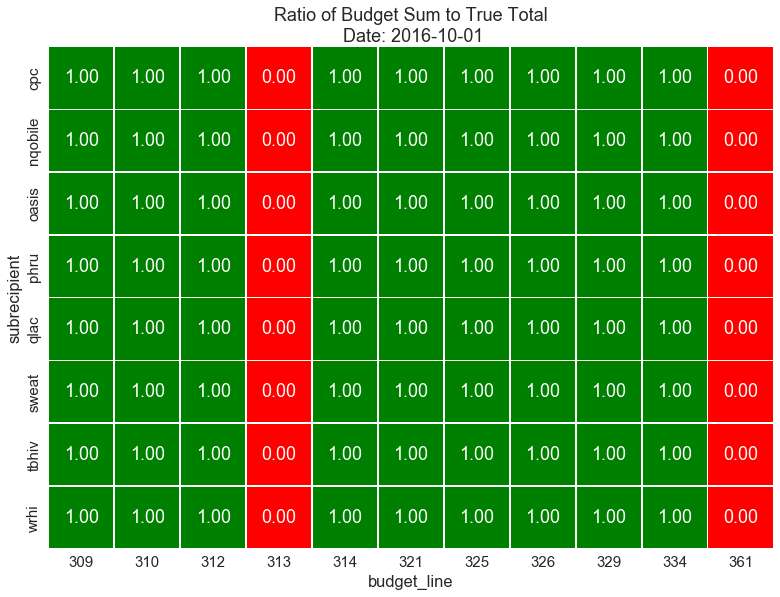

<function __main__.plot_budget>

In [198]:
name='budget'
agg_total=DF.loc[(DF['field'].str.contains(name+'_'))\
                        & (DF['qNum'] > 0)].groupby(['Date','subrecipient','budget_line']).val.sum()
total=DF.loc[(DF['field']==name)\
                        & (DF['qNum'] > 0)].groupby(['Date','subrecipient','budget_line']).val.sum()
ratio=agg_total/total

def plot_budget(t):
    
    index_num=t
    ind=ratio.index.levels[0][index_num]
    
    cmap = mpl.colors.ListedColormap(['red','yellow','green'])
    bounds=[0,0.01,0.98,1.02,1.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N+1)

    toplot=ratio[ind].dropna()

    result = pd.DataFrame(toplot).reset_index().pivot(index='subrecipient', columns='budget_line')['val'].dropna(axis=1)
    #result.columns=[val.split(':')[0] for val in result.columns]
    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.heatmap(result, annot=True, fmt=".2f", cmap=cmap, norm=norm, label='big',\
                 square=False,linewidths=0.5, cbar=False) #ListedColormap(['red','green', 'red']) #vmin=0,vmax=1.5
    plt.title('Ratio of Budget Sum to True Total\n Date: {:s}'.format(str(ind.date())))
    plt.show()
    
interact(plot_budget, t=(0,12,1) )

<h1> Visualize the spending </h1>

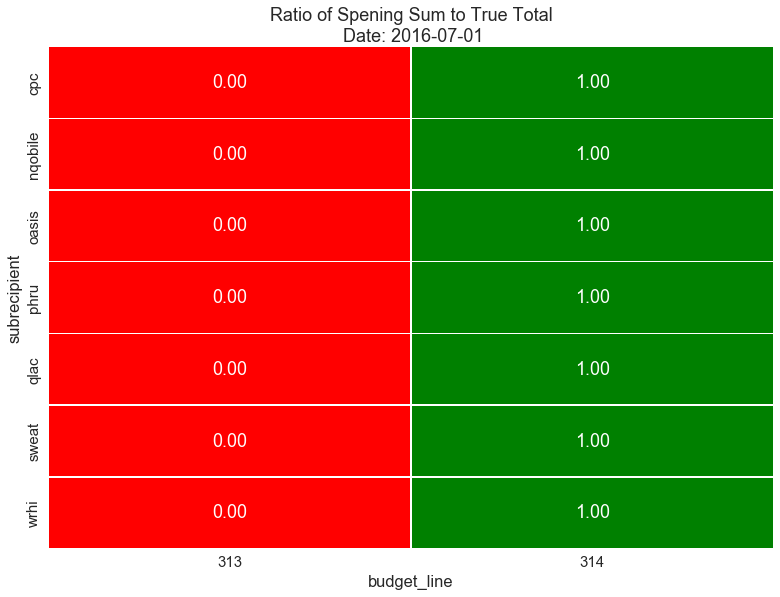

In [226]:
name='spend'
agg_total=DF.loc[(DF['field'].str.contains(name+'_'))\
                        & (DF['qNum'] > 0)].groupby(['Date','subrecipient','budget_line']).val.sum()
total=DF.loc[(DF['field']==name)\
                        & (DF['qNum'] > 0)].groupby(['Date','subrecipient','budget_line']).val.sum()
ratio=agg_total/total

def plot_spend(t):
    
    index_num=t
    ind=ratio.index.levels[0][index_num]
    
    cmap = mpl.colors.ListedColormap(['red','yellow','green'])
    bounds=[0,0.01,0.95,1.05]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    toplot=ratio.dropna()[ind]

    result = pd.DataFrame(toplot).reset_index().pivot(index='subrecipient', columns='budget_line')['val'].dropna(axis=1)
    #result.columns=[val.split(':')[0] for val in result.columns]
    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.heatmap(result, annot=True, fmt=".2f", cmap=cmap, norm=norm, label='big',\
                 square=False,linewidths=0.5, cbar=False) #ListedColormap(['red','green', 'red']) #vmin=0,vmax=1.5
    plt.title('Ratio of Spening Sum to True Total\n Date: {:s}'.format(str(ind.date())))
    plt.show()
    
interact(plot_spend, t=(0,6,1) )

<h1> ratio of spending on SW to total </h1>

In [223]:
name='spend'
agg_total=DF.loc[(DF['field'].str.contains(name+'_'))\
                        & (DF['qNum'] > 0)].groupby(['subrecipient', 'Date']).val.sum()
total=DF.loc[(DF['field']==name)\
                        & (DF['qNum'] > 0)].groupby(['subrecipient', 'Date']).val.sum()
SW_spend_ratio=agg_total/total

In [43]:
#setup colors
def plot_data(data,ylabel_str,xlab,loc):
    '''Format for plotting the data is to gorup by SR then Date'''
    start,stop=0,1
    number_of_colors= len(data.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.Accent(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4})

    for SR,color in zip(data.index.levels[0],colors):
        plt.plot(data[SR],'.-',color=color,markersize=20, label=SR,)
    ylabel(ylabel_str)
    xlabel(xlab)
    lg=plt.legend(loc=loc, numpoints=1,fontsize=14)
    frame = lg.get_frame()
    frame.set_facecolor('w')
    ax = gca()

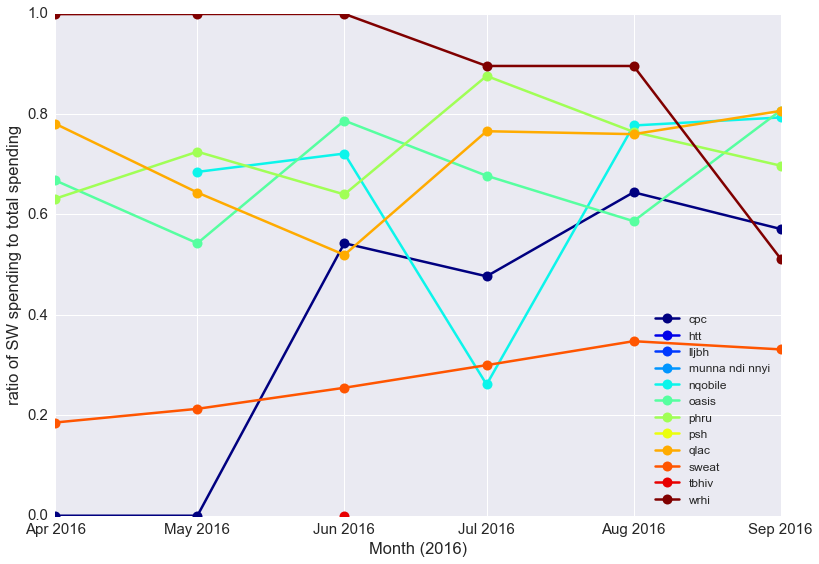

In [225]:
plot_data(SW_spend_ratio,'ratio of SW spending to total spending')

<h1> ratio of spending to budget </h1>

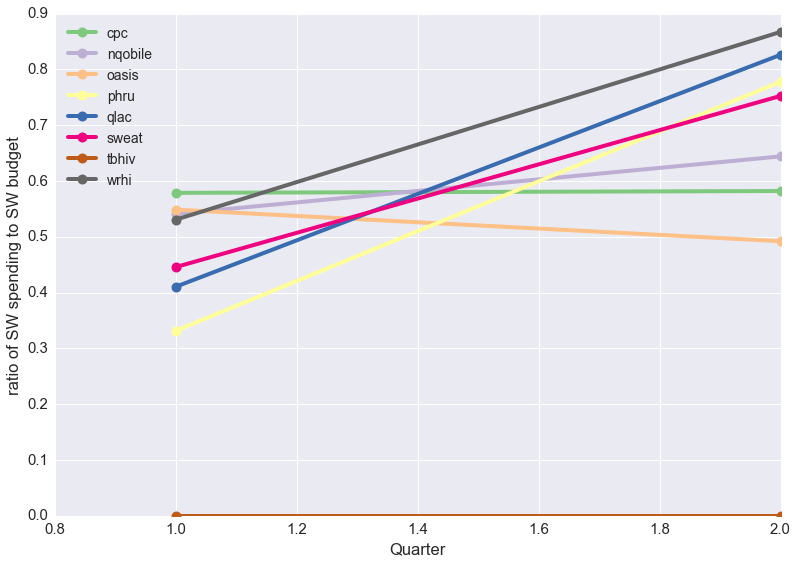

In [44]:
name='spend'
sw_spend=DF.loc[(DF['field'].str.contains(name+'_'))\
                        & (DF['qNum'] > 0) & (DF['qNum'] <= 2)].groupby(['subrecipient', 'qNum']).val.sum()
name='budget'
sw_budget=DF.loc[(DF['field'].str.contains(name+'_'))\
                        & (DF['qNum'] > 0) & (DF['qNum'] <= 2)].groupby(['subrecipient', 'qNum']).val.sum()
sw_spend_budget=sw_spend/sw_budget

plot_data(sw_spend_budget,'ratio of SW spending to SW budget','Quarter', 'upper left')

<h1> ratio of total spending to total budget (not just SW programs)  </h1>

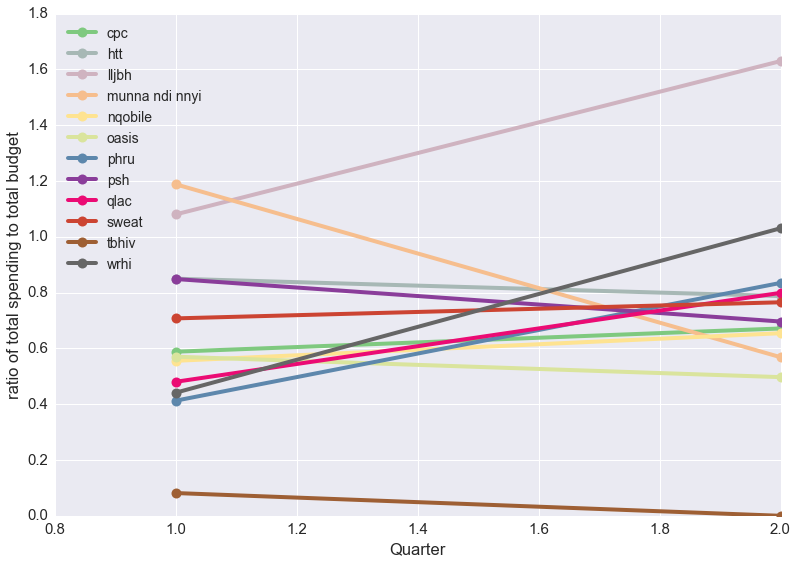

In [45]:
name='spend'
sw_spend=DF.loc[(DF['field']==name)\
                        & (DF['qNum'] > 0) & (DF['qNum'] <= 2)].groupby(['subrecipient', 'qNum']).val.sum() #qNum->Date
name='budget'
sw_budget=DF.loc[(DF['field']==name)\
                        & (DF['qNum'] > 0) & (DF['qNum'] <= 2)].groupby(['subrecipient', 'qNum']).val.sum()
sw_spend_budget=sw_spend/sw_budget

plot_data(sw_spend_budget,'ratio of total spending to total budget','Quarter','upper left')

<h1> Plot spending for each SR and M&E. Normalized to the total spent accross all SRs </h1>

In [ ]:
# The mapping has a fractional portion of the budget line to each M&E

In [6]:
name='budget'
qcut= (DF['qNum'] > 0) & (DF['qNum'] <= 2)

target_sum=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
            .groupby(['Date', 'field', 'subrecipient']).val.sum().dropna().groupby(level=[0,1])
#This way the sum across all SRs for one indicator is equal to 1

agg_total_per_me=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
            .groupby(['Date', 'field', 'subrecipient']).val.sum().dropna()
    
total_per_me_per_indicator=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
                        .groupby(['Date','field','subrecipient']).val.sum()\
                        .groupby(level=[0,1]).transform(lambda x: x/x.sum())
        
total_per_me_per_sr=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
                        .groupby(['Date','field','subrecipient']).val.sum()\
                        .groupby(level=[0,2]).transform(lambda x: x/x.sum())

In [143]:
#Test
#total_per_me_per_total.groupby(level=[0,1]).sum()

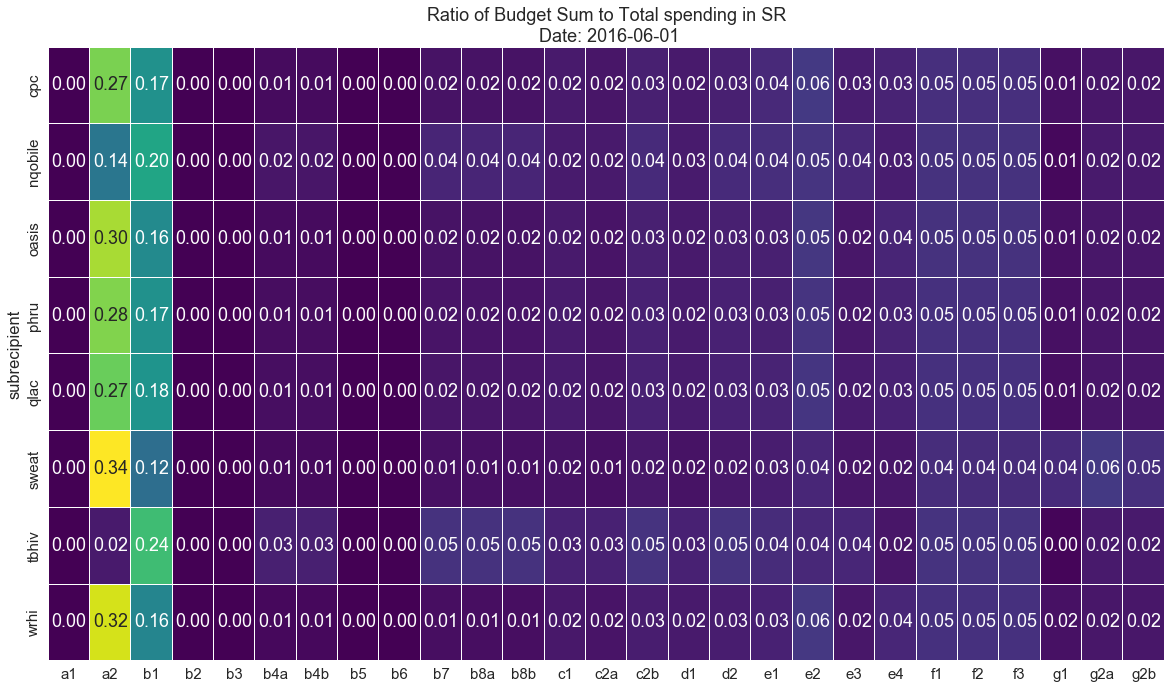

<function __main__.plot_me_budget>

In [226]:
def plot_me_budget(t, data):
    
    index_num=t
    ind=data.index.levels[0][index_num]
    
    #cmap = mpl.colors.ListedColormap(['red','yellow','green'])
    #bounds=[0,0.01,0.98,1.02,1.5]
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N+1)

    toplot=data[ind].replace(nan,0)
    toplot.replace(0,.0001)

    result = pd.DataFrame(toplot).reset_index().pivot(index='subrecipient', columns='field', values='val')
    result.columns=[val.split('_')[1] for val in result.columns]
    fig=figure()
    fig.set_size_inches(20, 11)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.heatmap(result, annot=True, fmt=".2f", cmap='viridis', label='big',\
                square=False,linewidths=0.1, cbar=False) #ListedColormap(['red','green', 'red']) #vmin=0,vmax=1.5
    plt.title('Ratio of Budget Sum to Total spending in SR\n Date: {:s}'.format(str(ind.date())))
    plt.show()
    
interact(plot_me_budget, t=(0,5,1), data=fixed(total_per_me_per_sr) )

<h1> relative to spending in each subrecipient </h1>

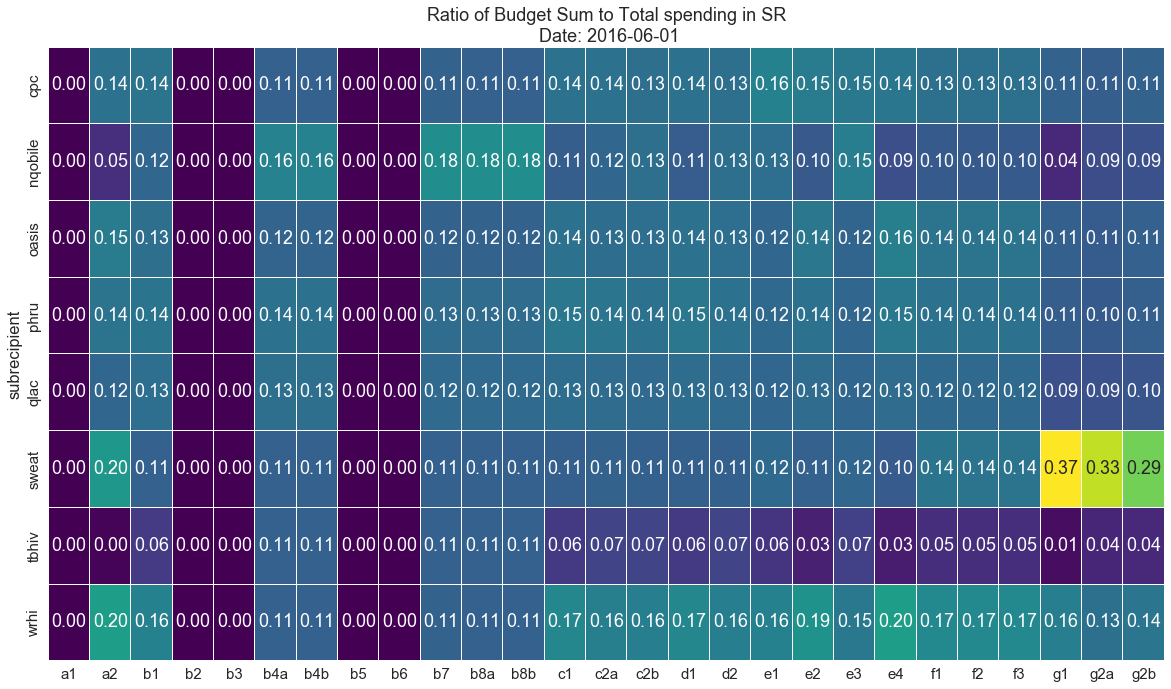

<function __main__.plot_me_budget>

In [227]:
interact(plot_me_budget, t=(0,5,1), data=fixed(total_per_me_per_indicator) )

In [406]:
total_per_me_per_sr

<read-write buffer for 0x1ea3676c0, size 10368, offset 0 at 0x1ec4f86f0>

<h1> Do this interaction in bokeh </h1>

In [156]:
from bokeh.io import show, output_notebook
from bokeh.charts import HeatMap, bins, output_file
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure as bfig
from bokeh.palettes import YlOrRd9 as palette
output_notebook()

Loading BokehJS ...

In [154]:
bokeh_data=total_per_me_per_sr['2016-04-01 00:00:00'].reset_index().dropna()
#bokeh_data

# pandas magic
df = bokeh_data[bokeh_data.columns[:]]
df2 = df.set_index(df[df.columns[0]].astype(str))
df2.drop(df.columns[0], axis=1, inplace=True)
df3 = df2.transpose()
df3

field,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,budget_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach,budget_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach,...,budget_g2a_number_of_human_rights_violations_sex_workers_cases_referred,budget_g2a_number_of_human_rights_violations_sex_workers_cases_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred,budget_g2b_number_of_human_rights_violations_sex_workers_cases_successfully_referred
subrecipient,cpc,nqobile,oasis,phru,qlac,sweat,tbhiv,wrhi,cpc,nqobile,...,tbhiv,wrhi,cpc,nqobile,oasis,phru,qlac,sweat,tbhiv,wrhi
val,0,0,0,0,0,0,0,0,0.274829,0.135107,...,0.0235486,0.0210133,0.0212467,0.0230454,0.020616,0.0201306,0.0198217,0.0470702,0.0234384,0.0209841


In [159]:
bokeh_data=total_per_me_per_sr['2016-04-01 00:00:00'].reset_index().dropna()
heat_data = {key:list(value.values.astype(str)) for key,value in bokeh_data.iteritems()}
data=dict(indicator=[val.split('_')[1] for val in heat_data['field']], subrecipient=heat_data['subrecipient'], rate=[float(val) for val in heat_data['val']])
hm= HeatMap(data, x='indicator', y='subrecipient', stat='mean', values='rate', palette=palette)
show(hm)

In [78]:
dict(field=heat_data['field'], subrecipient=heat_data['subrecipient'], val=heat_data['val'])

{'field': array([ 'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
        'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
        'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
        'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
        'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
        'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
        'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
        'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
        'spend_a2_number_of_sex_workers_who_received_one

In [120]:
heat_data = {key:list(value.values.astype(str)) for key,value in bokeh_data.iteritems()}
dict(field=heat_data['field'], subrecipient=heat_data['subrecipient'], val=[float(val) for val in heat_data['val']])

{'field': ['spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
  'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
  'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
  'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
  'spend_a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions',
  'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
  'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
  'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
  'spend_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach',
  'spend_a2_number

In [135]:
source = ColumnDataSource(
    data=dict(month=[val.split('_')[1] for val in heat_data['field']], year=heat_data['subrecipient'], rate=[float(val) for val in heat_data['val']])
)

TOOLS = "hover,save,pan,box_zoom,wheel_zoom"

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors)

p = figure(title="US Unemployment (1948 - 2013)",
           y_range=list(heat_data['subrecipient']), x_range=[val.split('_')[1] for val in heat_data['field']],
           x_axis_location="above", plot_width=900, plot_height=400,
           tools=TOOLS)

#p.grid.grid_line_color = None
#p.axis.axis_line_color = None
#p.axis.major_tick_line_color = None
#p.axis.major_label_text_font_size = "5pt"
#p.axis.major_label_standoff = 0
#p.xaxis.major_label_orientation = pi / 3

p.rect(x="month", y="year", width=1, height=1,
       source=source,
       fill_color={'field': 'rate', 'transform': mapper},
       line_color=None)


show(p)      # show the plot

In [122]:
source = ColumnDataSource(data=bokeh_data) #['2016-04-01 00:00:00']

source = ColumnDataSource(
    data=dict(field=[val.split('_')[1] for val in heat_data['field']], subrecipient=heat_data['subrecipient'], val=[float(val) for val in heat_data['val']])
)

TOOLS = "hover,save,pan,box_zoom,wheel_zoom"
colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors)

p = figure(title="US Unemployment (1948 - 2013)",\
           x_axis_location="above", plot_width=900, plot_height=400,\
           tools=TOOLS)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
#p.xaxis.major_label_orientation = pi / 3

p.rect(x="field", y="subrecipient", width=1, height=1, source=source,
       fill_color={'field': 'val', 'transform': mapper})
       #line_color=None)

#p.select_one(HoverTool).tooltips = [
#    ('date', '@month @year'),
#    ('rate', '@rate'),
#]

show(p)      # show the plot

<h1> next plot the ratio of M&E value for that month to spending </h1>

<h3> this first has to be normalized to target, or it has to be normalized to the total over all SRs... else things like condoms distributed overshadown the others </h3>

In [ ]:
name='budget'
qcut= (DF['qNum'] > 0) & (DF['qNum'] <= 2)

target_sum=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
            .groupby(['Date', 'field', 'subrecipient']).val.sum().dropna().groupby(level=[0,1])
#This way the sum across all SRs for one indicator is equal to 1

agg_total_per_me=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
            .groupby(['Date', 'field', 'subrecipient']).val.sum().dropna()
    
total_per_me_per_indicator=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
                        .groupby(['Date','field','subrecipient']).val.sum()\
                        .groupby(level=[0,1]).transform(lambda x: x/x.sum())
        
total_per_me_per_sr=DF.loc[(DF['field'].str.contains(name+'_')) & (qcut)]\
                        .groupby(['Date','field','subrecipient']).val.sum()\
                        .groupby(level=[0,2]).transform(lambda x: x/x.sum())

In [ ]:
interact(plot_me_budget, t=(0,5,1), data=fixed(total_per_me_per_indicator) )

In [48]:
indicator_values=DF.loc[(DF['field'].str.contains('_number_of')) & ~(DF['field'].str.contains('target')) &
       ~(DF['field'].str.contains('spend')) & ~(DF['field'].str.contains('budget')) \
                        & ~(DF['field'].str.contains('total_other')) & (qcut)]\
    .groupby(['qNum', 'field', 'subrecipient']).val.sum().dropna()

name='budget'
DF_temp=DF.loc[(DF['field'].str.contains('_number_of')) & (DF['field'].str.contains(name)) & (qcut)]
DF_temp['field'].replace(regex=True,inplace=True,to_replace=r'budget_',value=r'')

finance_values=DF_temp.groupby(['qNum', 'field', 'subrecipient']).val.sum().dropna()


In [49]:
def plot_ind2budget(t, data):
    
    index_num=t
    ind=data.index.levels[0][index_num]
    
    #cmap = mpl.colors.ListedColormap(['red','yellow','green'])
    #bounds=[0,0.01,0.98,1.02,1.5]
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N+1)

    toplot=data[ind].replace(nan,0)
    toplot=toplot.dropna()
    toplot/=toplot.groupby(level=0).sum()

    result = pd.DataFrame(toplot).reset_index().pivot(index='subrecipient', columns='field', values='val')
    result.columns=[val.split('_')[0] for val in result.columns]
    fig=figure()
    fig.set_size_inches(20, 11)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.heatmap(result, annot=True, fmt=".2f", cmap='viridis', label='big',\
                square=False,linewidths=0.1, cbar=False) #ListedColormap(['red','green', 'red']) #vmin=0,vmax=1.5
    plt.title('Ratio of M&E value to spending in SR\n Quarter: {:s}'.format(str(ind)))
    plt.show()
    

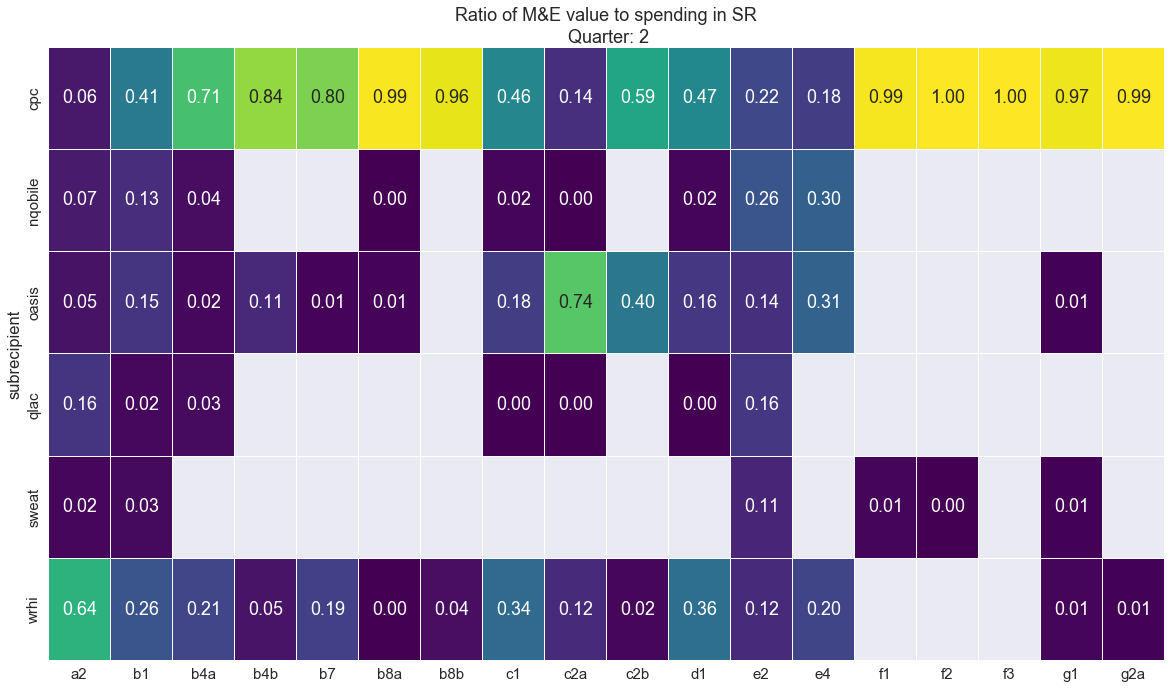

<function __main__.plot_ind2budget>

In [50]:
ind_over_budget=indicator_values/finance_values
ind_over_budget=ind_over_budget.replace(inf,nan).dropna()

interact(plot_ind2budget, t=(1,2,1), data=fixed(ind_over_budget) )

<h1> then do the M&E value to spending relative to the total in an SR </h1>

<h1> plot M&E target value to spending </h1> ... gauge ambition

In [67]:
def plot_ambition(t, data, norm, title, val='val'):
    
    index_num=t
    ind=data.index.levels[0][index_num]
    
    #cmap = mpl.colors.ListedColormap(['red','yellow','green'])
    #bounds=[0,0.01,0.98,1.02,1.5]
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N+1)

    toplot=data[ind].replace(nan,0)
    toplot=toplot.dropna()
    if norm == 'mean':
        toplot/=toplot.groupby(level=0).mean()
    elif norm == 'sum':
        toplot/=toplot.groupby(level=0).sum()
    else:
        toplot=toplot

    result = pd.DataFrame(toplot).reset_index().pivot(index='subrecipient', columns='field', values=val)
    result.columns=[val.split('_')[0] for val in result.columns]
    fig=figure()
    fig.set_size_inches(20, 11)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.heatmap(result, annot=True, fmt=".2f", cmap='viridis', label='big',\
                square=False,linewidths=0.1, cbar=False) #ListedColormap(['red','green', 'red']) #vmin=0,vmax=1.5
    plt.title('{:s}\n Quarter: {:s}'.format(title, str(ind)))
    plt.show()

In [204]:
def add_one_month(Date):
    if Date.month < 12:
        year=Date.year
        month=Date.month+1
    else:
        year=Date.year+1
        month=1
    return pd.datetime(year,month,1)

In [162]:
DF_temp['year'].values[0]
Date=pd.datetime(DF_temp['year'].values[0],DF_temp['month'].values[0],DF_temp['day'].values[0])
Date.strftime('%Y-%m-%d')

d2=add_one_month(Date)
add_one_month(d2)

'2016-04-01'

In [220]:
DF.loc[DF['field'].str.contains('target')].set_index('Real_Date')

,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,field,gender,...,suburb,supplier_employee_name,transaction_reference,unique_id,val,Date,day,month,year,qNum
Real_Date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,3780.0,2016-04-01,1,4,2016,1
2016-07-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,6300.0,2016-07-01,1,7,2016,2
2016-10-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2016-10-01,1,10,2016,3
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2017-01-01,1,1,2017,4
2017-04-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2017-04-01,1,4,2017,5
2017-07-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2017-07-01,1,7,2017,6
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2017-10-01,1,10,2017,7
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2018-01-01,1,1,2018,8
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,total,total (non-transition only),target_total_non_transition_a1_number_of_sex_w...,NaN,...,NaN,NaN,NaN,NaN,8820.0,2018-04-01,1,4,2018,9


<h1> code to interpolate target dates </h1>

In [280]:
new_target_date=[]
new_target_date2=[]
new_target_date3=[]

for row in DF.loc[DF['field'].str.contains('target')].iterrows():
    row= row[1].to_dict()
    row['val'] = row['val'] / 3
    Date=row['Date']
    new_target_date.append(row)

for row2 in DF.loc[DF['field'].str.contains('target')].iterrows():
    #add one month
    row2= row2[1].to_dict()
    row2['val'] = row2['val'] / 3
    Date=row2['Date']
    
    Date=add_one_month(Date)
    row2['Real_Date']= Date.strftime('%Y-%m-%d')
    new_target_date2.append(row2)

for row3 in DF.loc[DF['field'].str.contains('target')].iterrows():
    #add one month
    row3= row3[1].to_dict()
    row3['val'] = row3['val'] / 3
    Date=row3['Date']

    Date=add_one_month(add_one_month(Date))
    row3['Real_Date']= Date.strftime('%Y-%m-%d')
    new_target_date3.append(row3)

SUM_targerts=new_target_date+new_target_date2+new_target_date3   

In [288]:
DF_monthly_targets=pd.DataFrame(SUM_targerts) #.groupby(['field','Real_Date']).val.sum()

In [286]:
DF_no_targets=DF.loc[~DF['field'].str.contains('target')]

In [290]:
DF_total=DF_no_targets.append(DF_monthly_targets)

In [293]:
DF=DF_total

In [294]:
qcut= (DF['qNum'] > 0) & (DF['qNum'] <= 2)

DF_temp=DF.loc[(DF['field'].str.contains('target')) & (qcut)]
DF_temp['field'].replace(regex=True,inplace=True,to_replace=r'target_',value=r'')
target_values=DF_temp.groupby(['qNum', 'field', 'subrecipient']).val.sum().dropna()
target_values

qNum  field                                                                                                                               subrecipient
1     a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions                   cpc                3780.0
                                                                                                                                          nqobile            1260.0
                                                                                                                                          oasis              2520.0
                                                                                                                                          phru               2520.0
                                                                                                                                          qlac               2520.0
                             

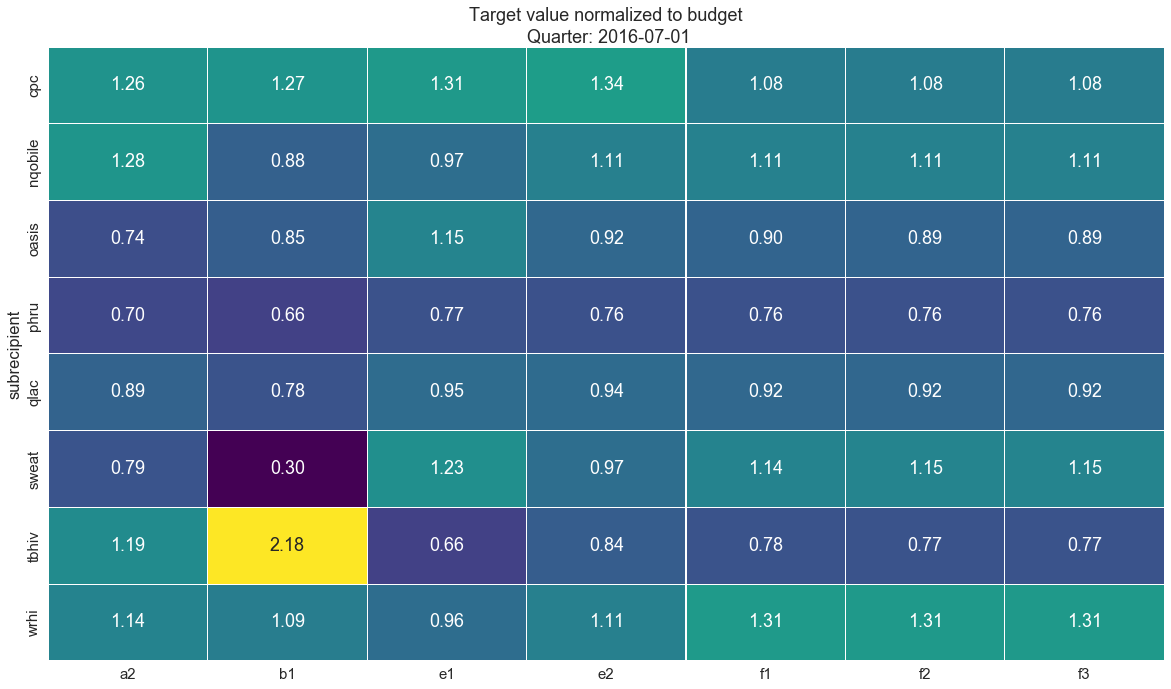

<function __main__.plot_ambition>

In [317]:
qcut= (DF['qNum'] > 0) & (DF['qNum'] <= 2)

DF_temp=DF.loc[(DF['field'].str.contains('target')) & (qcut)]
DF_temp['field'].replace(regex=True,inplace=True,to_replace=r'target_',value=r'')
target_values=DF_temp.groupby(['Real_Date', 'field', 'subrecipient']).val.sum().dropna()

name='budget'
DF_temp=DF.loc[(DF['field'].str.contains('_number_of')) & (DF['field'].str.contains(name)) & (qcut)]
DF_temp['field'].replace(regex=True,inplace=True,to_replace=name+r'_',value=r'')

finance_values=DF_temp.groupby(['Real_Date', 'field', 'subrecipient']).val.sum().dropna()

tar_over_budget=target_values/finance_values
tar_over_budget=tar_over_budget.replace(inf,nan).dropna()

interact(plot_ambition, t=(1,6,1), data=fixed(tar_over_budget),norm='mean', title='Target value normalized to budget' )

<h1> Spending normalized to Budget </h1>

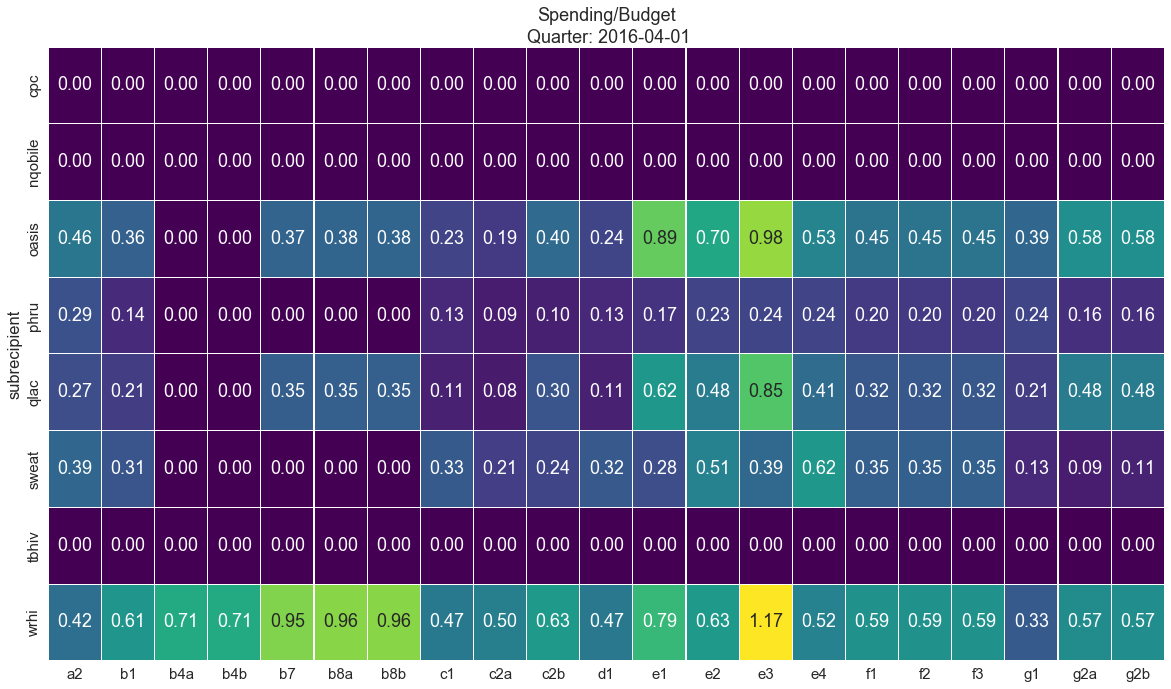

<function __main__.plot_ambition>

In [321]:
name='spend'
DF_temp=DF.loc[(DF['field'].str.contains('_number_of')) & (DF['field'].str.contains(name)) & (qcut)]
DF_temp['field'].replace(regex=True,inplace=True,to_replace=name+r'_',value=r'')

spend_values=DF_temp.groupby(['Real_Date', 'field', 'subrecipient']).val.sum().dropna()

name='budget'
DF_temp=DF.loc[(DF['field'].str.contains('_number_of')) & (DF['field'].str.contains(name)) & (qcut)]
DF_temp['field'].replace(regex=True,inplace=True,to_replace=name+r'_',value=r'')

budget_values=DF_temp.groupby(['Real_Date', 'field', 'subrecipient']).val.sum().dropna()

spend_over_budget=spend_values/budget_values
spend_over_budget=spend_over_budget.replace(inf,nan).dropna()

interact(plot_ambition, t=(0,1,1), data=fixed(spend_over_budget),norm='none', title= 'Spending/Budget' )

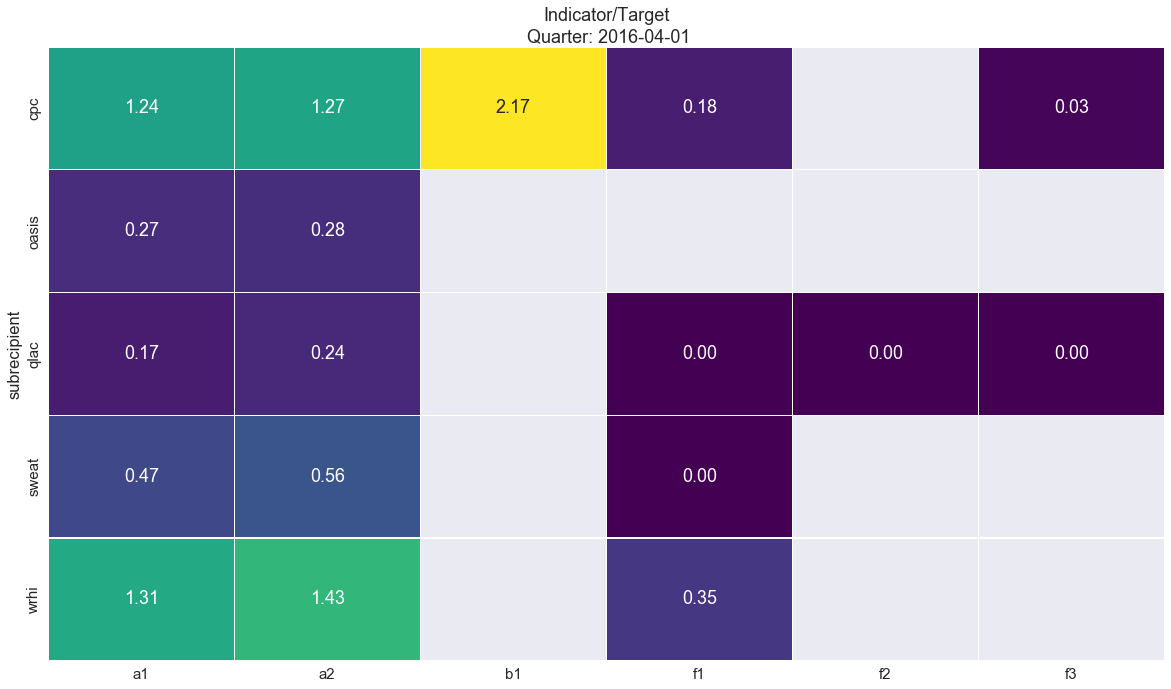

<function __main__.plot_ambition>

In [322]:
indicator_values=DF.loc[(DF['field'].str.contains('_number_of')) & ~(DF['field'].str.contains('target')) &
       ~(DF['field'].str.contains('spend')) & ~(DF['field'].str.contains('budget')) \
                        & ~(DF['field'].str.contains('total_other')) & (qcut)]\
    .groupby(['Real_Date', 'field', 'subrecipient']).val.sum().dropna()#unique_id.nunique().dropna(), val.sum()

ind2tar = (indicator_values/target_values).dropna()
interact(plot_ambition, t=(0,1,1), data=fixed(ind2tar),norm='none', title= 'Indicator/Target',val='val' ) #0 with unique

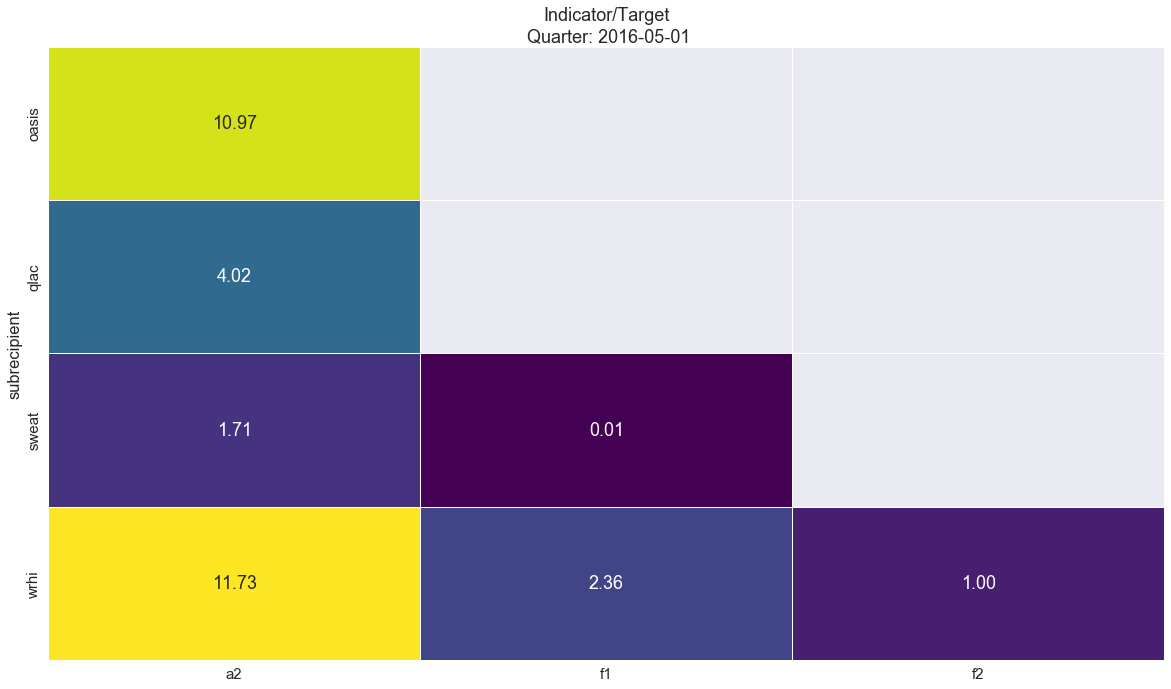

<function __main__.plot_ambition>

In [341]:
efficiency = (indicator_values / target_values).dropna() / (spend_values / finance_values).dropna()
efficiency=efficiency.replace(inf,nan).dropna()
interact(plot_ambition, t=(0,3,1), data=fixed(efficiency),norm='none', title= 'Indicator/Target', val='val' ) 

In [326]:
A=ind2tar.reset_index()
prefix='score'
A['field'] = [prefix+'_'+val for val in A['field']]

In [327]:
A

,Real_Date,field,subrecipient,val
0,2016-04-01,score_a1_number_of_sex_workers_reached_with_hi...,cpc,1.238095
1,2016-04-01,score_a1_number_of_sex_workers_reached_with_hi...,oasis,0.272619
2,2016-04-01,score_a1_number_of_sex_workers_reached_with_hi...,qlac,0.175000
3,2016-04-01,score_a1_number_of_sex_workers_reached_with_hi...,sweat,0.470238
4,2016-04-01,score_a1_number_of_sex_workers_reached_with_hi...,wrhi,1.313492
5,2016-04-01,score_a2_number_of_sex_workers_who_received_on...,cpc,1.268254
6,2016-04-01,score_a2_number_of_sex_workers_who_received_on...,oasis,0.282143
7,2016-04-01,score_a2_number_of_sex_workers_who_received_on...,qlac,0.244048
8,2016-04-01,score_a2_number_of_sex_workers_who_received_on...,sweat,0.561905
9,2016-04-01,score_a2_number_of_sex_workers_who_received_on...,wrhi,1.430159


<h1> Drop duplicate entrires for the month </h1>

In [7]:
len(DF.loc[DF['field']=='a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach']\
    .drop_duplicates(['subrecipient','province','qNum','unique_id']))

201001

In [8]:
DF_dropped = DF.dropna(subset=['unique_id']).drop_duplicates(['field','subrecipient','province','qNum','unique_id'])

In [40]:
len(DF_dropped)

805154

In [27]:
DF_dropped['first_of_quarter']=1

In [36]:
DF_joined = DF.join(DF_dropped['first_of_quarter'], how='left')
DF_joined['first_of_quarter'] = DF_joined['first_of_quarter'].fillna(0).astype(int)
#DF_joined['first_of_quarter']=DF_joined['first_of_quarter'].astype(int)
DF_joined.loc[DF_joined['first_of_quarter']==1]

,Real_Date,age,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,...,transaction_reference,unique_id,val,Date,day,month,year,YearMonth,qNum,first_of_quarter
274450,2014-10-01,referred for treatment,cat mah,b-1971-1975,NaN,NaN,cd4,NaN,NaN,NaN,...,NaN,catmahb-1971-1975female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274451,2014-10-01,referred for treatment,phi msh,e-1986-1990,NaN,NaN,cd4,NaN,NaN,NaN,...,NaN,phimshe-1986-1990female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274452,2014-10-01,referred for treatment,hap the,d-1981-1985,NaN,NaN,cd4,NaN,NaN,NaN,...,NaN,hapthed-1981-1985female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274453,2014-10-01,referred for treatment,syl mgi,e-1986-1990,NaN,NaN,cd4,NaN,NaN,NaN,...,NaN,sylmgie-1986-1990female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274454,2014-10-01,,oum sel,d-1981-1985,NaN,NaN,consent form,NaN,NaN,NaN,...,NaN,oumseld-1981-1985female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274455,2014-10-01,,pat mol,b-1971-1975,NaN,NaN,consent form,NaN,NaN,NaN,...,NaN,patmolb-1971-1975female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274456,2014-10-01,,ath chi,d-1981-1985,NaN,NaN,consent form,NaN,NaN,NaN,...,NaN,athchid-1981-1985female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274457,2014-10-01,,amu mzi,e-1986-1990,NaN,NaN,consent form,NaN,NaN,NaN,...,NaN,amumzie-1986-1990female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274458,2014-10-01,,dip mas,e-1986-1990,NaN,NaN,consent form,NaN,NaN,NaN,...,NaN,dipmase-1986-1990female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1
274459,2014-10-01,,joy ngo,d-1981-1985,NaN,NaN,consent form,NaN,NaN,NaN,...,NaN,joyngod-1981-1985female,1.0,2014-10-01,1,10,2014,2014-10-1,-5,1


In [39]:
DF_joined.loc[DF_joined['first_of_quarter']==1].groupby('age').count()

,Real_Date,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,field,...,transaction_reference,unique_id,val,Date,day,month,year,YearMonth,qNum,first_of_quarter
age,,,,,,,,,,,,,,,,,,,,,
,796073,796073,796073,0,0,796073,0,0,0,796073,...,0,796073,796073,796073,796073,796073,796073,796073,796073,796073
0.0,10,10,10,0,0,10,0,0,0,10,...,0,10,10,10,10,10,10,10,10,10
16.0,2,2,2,0,0,2,0,0,0,2,...,0,2,2,2,2,2,2,2,2,2
17.0,12,12,12,0,0,12,0,0,0,12,...,0,12,12,12,12,12,12,12,12,12
18.0,32,32,32,0,0,32,0,0,0,32,...,0,32,32,32,32,32,32,32,32,32
19.0,44,44,44,0,0,44,0,0,0,44,...,0,44,44,44,44,44,44,44,44,44
1956.0,3,3,3,0,0,3,0,0,0,3,...,0,3,3,3,3,3,3,3,3,3
1959.0,4,4,4,0,0,4,0,0,0,4,...,0,4,4,4,4,4,4,4,4,4
1960.0,26,26,26,0,0,26,0,0,0,26,...,0,26,26,26,26,26,26,26,26,26


In [9]:
DF_dropped.groupby('field').count()

,Real_Date,age,beneficiary,birth,budget_line,budget_line_full,comments,cost_category,description,district,...,supplier_employee_name,transaction_reference,unique_id,val,Date,day,month,year,YearMonth,qNum
field,,,,,,,,,,,,,,,,,,,,,
a1_number_of_sex_workers_reached_with_hiv_prevention_programs_individual_and_or_smaller_group_level_interventions,201001,201001,201001,201001,0,0,201001,0,0,0,...,0,0,201001,201001,201001,201001,201001,201001,201001,201001
a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach,201001,201001,201001,201001,0,0,201001,0,0,0,...,0,0,201001,201001,201001,201001,201001,201001,201001,201001
b1_number_of_sex_workers_that_have_received_an_hiv_test_during_the_reporting_period_and_know_their_results,16798,16798,16798,16798,0,0,16798,0,0,0,...,0,0,16798,16798,16798,16798,16798,16798,16798,16798
b2_number_of_sex_workers_who_tested_hiv_negative_in_the_reporting_period,1422,1422,1422,1422,0,0,1422,0,0,0,...,0,0,1422,1422,1422,1422,1422,1422,1422,1422
b3_number_of_newly_diagnosed_hiv_positive_sex_workers,503,503,503,503,0,0,503,0,0,0,...,0,0,503,503,503,503,503,503,503,503
b4a_number_of_newly_diagnosed_hiv_positive_sex_workers_referred_for_art,695,695,695,695,0,0,695,0,0,0,...,0,0,695,695,695,695,695,695,695,695
b4b_number_of_newly_diagnosed_hiv_positive_sex_workers_initiated_on_art,371,371,371,371,0,0,371,0,0,0,...,0,0,371,371,371,371,371,371,371,371
b5_number_of_sex_workers_with_known_hiv_positive_status,6191,6191,6191,6191,0,0,6191,0,0,0,...,0,0,6191,6191,6191,6191,6191,6191,6191,6191
b6_number_of_sex_workers_who_refused_hiv_test,289,289,289,289,0,0,289,0,0,0,...,0,0,289,289,289,289,289,289,289,289


In [111]:
len(DF_dropped.loc[DF_dropped['field']=='a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach']\
    .drop_duplicates(['subrecipient','province','qNum','unique_id']))

177195

In [20]:
Indicator='budget_a2_number_of_sex_workers_who_received_one_or_more_services_through_outreach'
DF.loc[(DF['field']==Indicator)\
                        & (DF['qNum']>0)].groupby(['subrecipient','Date']).val.sum()

subrecipient  Date      
cpc           2016-04-01     59084.871168
              2016-05-01     59084.871168
              2016-06-01     59084.871168
              2016-07-01     93665.136501
              2016-08-01     93665.136501
              2016-09-01     93665.136501
              2016-10-01    139801.636501
              2016-11-01    139801.636501
              2016-12-01    139801.636501
              2017-01-01    139801.636501
              2017-02-01    139801.636501
              2017-03-01    139801.636501
              2017-04-01    269564.520312
              2017-05-01    269564.520312
              2017-06-01    269564.520312
              2017-07-01    268788.411192
              2017-08-01    268788.411192
              2017-09-01    268788.411192
              2017-10-01    268788.411192
              2017-11-01    268788.411192
              2017-12-01    268788.411192
              2018-01-01    268788.411192
              2018-02-01    268788.411192
         